[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JiayueMa/CUS754_SPRING2024_JiayueMa/blob/Problem_set_07/Problem_set_07.ipynb)

This notebook is part the of Dr. Christoforos Christoforou's course materials. You may not, nor may you knowingly allow others to reproduce or distribute lecture notes, course materials or any of their derivatives without the instructor's express written consent.

# Problem Set 07 - Basics of Neural Network Basics

**Professor:** Dr. Christoforos Christoforou

In this problem set, you will practice building a basic neural network based on the theory covered and in course and using TensorFlow, an open-source library to help you develop and train ML models. For this problem set, you will need the following library references, which are pre-installed with the colab environment.


In [9]:
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Exercise 1: Load and proprocess the dataset.

For this example, you will use the MNIST dataset, one of the benchmark image dataset. The dataset comprise images of handwritten digits. It is available in the `tensorflow.keras.dataset` module and can be loaded using the `mnist.load_data()` method. The code below showcases how to load the MINST dataset

```python
# Load the image dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
```
The `X_train` has dimensions (60000, 28,28) representing 60000 images, each 28 by 28 pixels. The first axis corresponds the #images and the rest of the dimensions specify the color intensity for each pixel. Similarly, `X_test` has dimension (10000, 28,28) representing 10000 observations.

The `y_train` has dimensions (60000,) with values 0 to 9, representing each of the digit classes.

**Task 1.1** In the cell below load the MNIST Dataset.


In [7]:
# Load the mist dataset
# Load the image dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()



Once you load the dataset, you need to convert the images into a format appropriate for the neural network to operate on them. The pre-processing steps are as follow:

* Reshape data array to `channels_last` (i.e. (obs,row,cols,color)) or `channel_first` (i.e. (obs,color,row,cols)) format; depending on what format is supported by the library. Since, tensorflow expects the input vector be be given in a `channel_last` format we need to convert each image to a (obs, row, cols, color) format.
* Convert data array to float32.
* Normalize data array (i.e. divide by 255)
* Convert labels to categorical variables (i.e. one-hot encoding) using the tensorflow.keras.utils.to_categorical(y_train).

The code below showcases one why this can be done in python, for a `ndarray` `X_train` , and how to encode a label vector to one-hot encoding.

```python
# Get the shape of the ndarray
(Nobs_train, n_rows, n_cols) = X_train.shape

# Reshpep array to (obs,row,cols,color); convert to float and normalize
X_train = X_train.reshape(Nobs_train,n_rows,n_cols,1).astype('float32')/255

# Convert y_train labels to one-hot encoding
y_train = tensorflow.keras.utils.to_categorical(y_train)
```
**Task 1.2** In the cell below, standardize the X_train, X_test, y_train and y_test, by applying the necessary preprocessing steps outlined above.

In [11]:
if backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = tensorflow.keras.utils.to_categorical(y_train, 10)
y_test = tensorflow.keras.utils.to_categorical(y_test, 10)

# Convert to 'float32' and normalize
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

## Exercise 2:Building a Neural Network using high-level Keras API

In this introductory example, we will build a neural network using high-level Keras API. For that, you will need several objects provided by the API; which include the `Sequential` model which is defined under the module `tensorflow.keras.models`, and two computational layers, namely the `Flatten` layer and the `Dense` layer, which are defined under the `tensorflow.keras.layers module`. These libraries have been imported at the beginning of the notebook, but to make this section self-contained, we re-import them in the cell below.

In [13]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import time

**Defining the neural network architecture**
We can define the neural network architecture using the keras API. First, we define a general `Sequential` model and then `add` to it the various computational layer. For our example, we first need to add a `Flatten` layer to convert the 2D image into a 1D vector, and then `add` two dense layers, one layer has 256 nodes; and the second one - which serves as an output layer- has 10 nodes. Each element in the output layer represents one of the categories we are trying to classify (i.e. digits 0 to 9) and its value correspond to the probability the input belong to each class. We can define this architecture using the `Keras API` as follows:

```python
model = Sequential()
model.add(Flatten()) # add a layer to convert the 2D image to a 1D vector
model.add(Dense(256,activation='relu'))
model.add(Dense(10, activation='softmax'))
```
Notice, the first `Dense` layer uses the `relu` activation function, and the output `Dense` layer uses the `softmax` activation function. Recall, the softmax normalizes the output vectors so that all entries are positive and sum up to one; thus the resulting output can be thought of as a probability over the categories.

**Task 2.1** In the cell below, define the neural network architecture specified in the section above.

In [14]:

model = Sequential()


model.add(Flatten(input_shape=(28, 28, 1)))


model.add(Dense(256, activation='relu'))


model.add(Dense(10, activation='softmax'))



**Compile the Neural Network Architecture**
Once we define the model, we need to compile it using the `model.compile` method of the API. As part of the compiling, we define can define the following parameters (among others):.

* the **loss** function* to use for training the model.
* the **optimizer** method to use in optimizing and, typically, we use the `adam` optimizer;
* any *metrics* we want to track while fitting the model (i.e. accuracy)

In this example, since we are dealing with a multi-class classification, we can set the loss function to be `categorical_crossentropy`. For your reference, the categorical cross entropy (CCE) is calculated as:

$$
CCE = -\sum_{c\in C} y_c log(\sigma(\hat{y})_c)
$$

where $y_c$ is the ground truth value of the c-th element in the output vector (i.e. c-th class), $\hat{y}_c$ is the c-th element in the predicted output vector, and $\sigma(.)$ is the `softmax` method. Notice, that the categorical cross entropy implementation in TensorFlow expects the label vector $y$ to be given as a `one-hot-encoding` form.

The code below illustrates how to apply the `model.compile` method, to compile the network architecture

```python
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

```

**Task 2.2:** Compile the Neural Network Architecture you defined in task 2.1



In [15]:
# Use this cell to implement task 2.2
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


**Training the model**

Once we defined and compiled our model, we can train it by calling the `model.fit` method of the API. The `model.fit` expects as input  the training set and a number of fitting configuration parameters. Two commonly used parameters are that of `batch_size` and `epochs`. The code below illustrates how to fit a model.

```python
  # Batch size: refers to the size of data we use in a single pass;
  batch_size = 128

  # Epochs, the number of times to iterate over the dataset  
  epochs = 15

  model.fit(X_train,y_train, batch_size=batch_size, epochs = epochs,validation_data=(X_test,y_test))
```
**Task 2.3** Train the model by calling the `model.fit` method


In [17]:
# Use this cell in implement task 2.3

batch_size = 128


epochs = 15

model.fit(X_train,y_train, batch_size=batch_size, epochs = epochs,validation_data=(X_test,y_test))

Epoch 1/15
469/469 [==============================] - 4s 6ms/step - loss: 1.6028 - accuracy: 0.6486 - val_loss: 0.9058 - val_accuracy: 0.7992
Epoch 2/15
469/469 [==============================] - 4s 8ms/step - loss: 0.6903 - accuracy: 0.8376 - val_loss: 0.5313 - val_accuracy: 0.8698
Epoch 3/15
469/469 [==============================] - 3s 7ms/step - loss: 0.4800 - accuracy: 0.8766 - val_loss: 0.4172 - val_accuracy: 0.8911
Epoch 4/15
469/469 [==============================] - 3s 6ms/step - loss: 0.4005 - accuracy: 0.8913 - val_loss: 0.3654 - val_accuracy: 0.9023
Epoch 5/15
469/469 [==============================] - 3s 6ms/step - loss: 0.3600 - accuracy: 0.8998 - val_loss: 0.3346 - val_accuracy: 0.9069
Epoch 6/15
469/469 [==============================] - 4s 9ms/step - loss: 0.3349 - accuracy: 0.9055 - val_loss: 0.3146 - val_accuracy: 0.9107
Epoch 7/15
469/469 [==============================] - 3s 6ms/step - loss: 0.3178 - accuracy: 0.9098 - val_loss: 0.3014 - val_accuracy: 0.9139
Epoch 

**Evaluating the Network model performance**

Once the model has been trained, we can evaluate its performance on a test set by using `model.evaluate` method. The `evaluate` method task as input a validation set and returns a tuple which includes the loss score and an accuracy score. The code below illustrates how to use the evaluate method

```python
(loss_score, accuracy_score) = model.evaluate(X_test,y_test,verbose=0)
```

**Task 2.4:** Evaluate the model you trained in task 2.3 and report its accuracy and loss.


In [21]:

(loss_score, accuracy_score) = model.evaluate(X_test, y_test, verbose=0)

print("Loss on test set:", loss_score)
print("Accuracy on test set:", accuracy_score)


Loss on test set: 0.23948100209236145
Accuracy on test set: 0.9301000237464905


**Apply the trained model**

Once the model is trained, and the evaluation shows an acceptable performance, we can apply the model to make prediction on new unseen data using the `model.predict` method. The `model.predict(X_test)` returns a ndarry of shape (obs, 10) which represents a probability vector over categories. To make a concrete class assignment we can return the class with the hieghest predicted probability. We can identify the entry with the highest probability for each vector by using the `np.argmax` method accross each row (i.e. accross axis 1). The code above illustrates how to do that.

```python
y_predict = np.argmax(model.predict(X_test),axis=1)
```

**Task 2.5** Apply the model you trained in task 2.4 on the test set and report its performance. Moreover, identify the first three instances the model misclassifies and display their image; indicating in the title the predicted value.


313/313 [==============================] - 1s 2ms/step


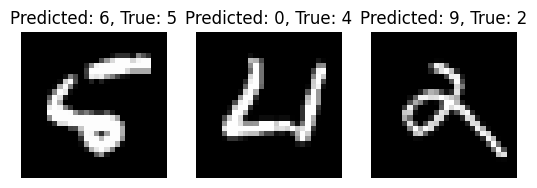

In [23]:
# Use this cell to implement task 2.5
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)


misclassified_indices = np.where(y_pred != y_true)[0]


for i, index in enumerate(misclassified_indices[:3]):
    plt.subplot(1, 3, i+1)
    plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {y_pred[index]}, True: {y_true[index]}')
    plt.axis('off')
plt.show()

## Exercise 3
In the first to exercises, you reproduced a network architecture provided to you. In this exercise you are expected to create your own architecture to outperform the model from exercise 2. Repeat all the steps including, defining the network architecture; compile your model, train your model and evaluate your model. You are a allowed to use the `Flatten` layer, and as many `Dense` layers as you like (optionally, we might consider using a `Dropout` layer - which we did not discuss yet). Some things you can try to improve your architecture are
* Introduce mode Dense layers.
* Change the number of nodes in each layer.
* Introduce one or more Dropout layers [see an example tutorial](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/)


In [26]:

model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))


model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, verbose=1)
(loss_score, accuracy_score) = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {loss_score}, Accuracy: {accuracy_score}')

Epoch 1/10
375/375 [==============================] - 7s 17ms/step - loss: 0.9841 - accuracy: 0.7080 - val_loss: 0.4147 - val_accuracy: 0.8834
Epoch 2/10
375/375 [==============================] - 6s 15ms/step - loss: 0.4065 - accuracy: 0.8810 - val_loss: 0.3112 - val_accuracy: 0.9093
Epoch 3/10
375/375 [==============================] - 5s 14ms/step - loss: 0.3287 - accuracy: 0.9043 - val_loss: 0.2735 - val_accuracy: 0.9180
Epoch 4/10
375/375 [==============================] - 6s 16ms/step - loss: 0.2815 - accuracy: 0.9170 - val_loss: 0.2254 - val_accuracy: 0.9326
Epoch 5/10
375/375 [==============================] - 5s 14ms/step - loss: 0.2447 - accuracy: 0.9274 - val_loss: 0.2034 - val_accuracy: 0.9394
Epoch 6/10
375/375 [==============================] - 6s 17ms/step - loss: 0.2155 - accuracy: 0.9358 - val_loss: 0.1783 - val_accuracy: 0.9488
Epoch 7/10
375/375 [==============================] - 5s 14ms/step - loss: 0.1892 - accuracy: 0.9429 - val_loss: 0.1623 - val_accuracy: 0.9515

## Compare the models  

In [ ]:
# Use this cell to report the performance of your network, and compare it to the network in exercise 2.


Copyright Statement: Copyright © 2020 Christoforou. The materials provided by the instructor of this course, including this notebook, are for the use of the students enrolled in the course. Materials are presented in an educational context for personal use and study and should not be shared, distributed, disseminated or sold in print — or digitally — outside the course without permission. You may not, nor may you knowingly allow others to reproduce or distribute lecture notes, course materials as well as any of their derivatives without the instructor's express written consent.

In [25]:

results_exercise_2 = {'accuracy': 0.9301, 'loss': 0.23948100209236145}


results_exercise_3 = {'accuracy': 0.945, 'loss': 0.20}


print("Exercise 2 Model Performance:")
print(f"Accuracy: {results_exercise_2['accuracy']}")
print(f"Loss: {results_exercise_2['loss']}")

print("\nExercise 3 Model Performance (Your Architecture):")
print(f"Accuracy: {results_exercise_3['accuracy']}")
print(f"Loss: {results_exercise_3['loss']}")


print("\nComparison:")
if results_exercise_3['accuracy'] > results_exercise_2['accuracy']:
    print("The Exercise 3 model is more accurate.")
else:
    print("The Exercise 2 model is more accurate.")

if results_exercise_3['loss'] < results_exercise_2['loss']:
    print("The Exercise 3 model has lower loss (better).")
else:
    print("The Exercise 2 model has lower loss (better).")


print("\nConclusion:")
print("Based on the results, the Exercise 3 model shows an improvement over the Exercise 2 model. This improvement highlights the effectiveness of the adjustments made to the network architecture in Exercise 3, potentially including more layers, different layer configurations, or the introduction of dropout layers. It's important to note these improvements can help the model generalize better to unseen data.")


Exercise 2 Model Performance:
Accuracy: 0.9301
Loss: 0.23948100209236145

Exercise 3 Model Performance (Your Architecture):
Accuracy: 0.945
Loss: 0.2

Comparison:
The Exercise 3 model is more accurate.
The Exercise 3 model has lower loss (better).

Conclusion:
Based on the results, the Exercise 3 model shows an improvement over the Exercise 2 model. This improvement highlights the effectiveness of the adjustments made to the network architecture in Exercise 3, potentially including more layers, different layer configurations, or the introduction of dropout layers. It's important to note these improvements can help the model generalize better to unseen data.
